# AB Testing 

In [39]:
import pandas as pd
import statsmodels.stats.api as sms
from scipy.stats import shapiro, levene, mannwhitneyu

## Preprocessing

In [40]:
#### Load dataset
data = pd.read_csv('ab_data.csv')
data.head()

,user_id,timestamp,group,landing_page,converted
0,851104,11:48.6,control,old_page,0
1,804228,01:45.2,control,old_page,0
2,661590,55:06.2,treatment,new_page,0
3,853541,28:03.1,treatment,new_page,0
4,864975,52:26.2,control,old_page,1


In [41]:
#### Check format
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294480 entries, 0 to 294479
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294480 non-null  int64 
 1   timestamp     294480 non-null  object
 2   group         294480 non-null  object
 3   landing_page  294480 non-null  object
 4   converted     294480 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


In [42]:
#### Check values 
for x in data.columns: 
    print(x)
    print(data[x].values)

user_id
[851104 804228 661590 ... 715931 759899 643532]
timestamp
['11:48.6' '01:45.2' '55:06.2' ... '40:24.5' '20:29.0' '40:24.5']
group
['control' 'control' 'treatment' ... 'treatment' 'treatment' 'treatment']
landing_page
['old_page' 'old_page' 'new_page' ... 'new_page' 'new_page' 'new_page']
converted
[0 0 0 ... 0 0 0]


In [43]:
#### Check unique values
data.apply(lambda x: x.nunique())

user_id         290585
timestamp        35993
group                2
landing_page         2
converted            2
dtype: int64

In [44]:
#### Check null
data.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

In [45]:
#### Check duplicates
data[data['user_id'].duplicated()]['user_id'] # user_id 3895개 중복

2656      698120
2893      773192
7500      899953
8036      790934
10218     633793
           ...  
294309    787083
294328    641570
294331    689637
294355    744456
294478    759899
Name: user_id, Length: 3895, dtype: int64

In [46]:
data[data['user_id']==698120] # 각 그룹간에 독립적인 실험 조건을 유지해야 함.

,user_id,timestamp,group,landing_page,converted
988,698120,09:37.5,control,new_page,0
2656,698120,13:42.6,control,old_page,0


In [47]:
#### Remove duplicates
print(data.shape)
df = data.drop_duplicates(subset='user_id', keep=False) # keep=False: 중복되는 user_id 모두 삭제(기존 값도). 따라서 3895*2=7790개가 삭제됨.
print(df.shape)

(294480, 5)
(286690, 5)


In [48]:
df[df['user_id']==698120]

,user_id,timestamp,group,landing_page,converted


In [49]:
df[['group', 'landing_page']].value_counts()

group      landing_page
treatment  new_page        143397
control    old_page        143293
dtype: int64

#### Convert Timestamp
- Convert Timestamps to Total Seconds

In [50]:
df['timestamp'].head(1)

0    11:48.6
Name: timestamp, dtype: object

In [51]:
# Function to convert MM:SS.S to total seconds. (분:초 -> 초)로 바꿔주기
def convert_to_seconds(timestamp):
    if pd.isnull(timestamp):  # Handle missing values
        return None
    minutes, seconds = map(float, timestamp.split(':'))
    return minutes * 60 + seconds

df['total_seconds'] = df['timestamp'].apply(convert_to_seconds)

print(df)

        user_id timestamp      group landing_page  converted  total_seconds
0        851104   11:48.6    control     old_page          0          708.6
1        804228   01:45.2    control     old_page          0          105.2
2        661590   55:06.2  treatment     new_page          0         3306.2
3        853541   28:03.1  treatment     new_page          0         1683.1
4        864975   52:26.2    control     old_page          1         3146.2
...         ...       ...        ...          ...        ...            ...
294474   945152   51:57.1    control     old_page          0         3117.1
294475   734608   45:03.4    control     old_page          0         2703.4
294476   697314   20:29.0    control     old_page          0         1229.0
294477   715931   40:24.5  treatment     new_page          0         2424.5
294479   643532   40:24.5  treatment     new_page          0         2424.5

[286690 rows x 6 columns]


C:\Users\eunseok\AppData\Local\Temp\ipykernel_22964\3764652170.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['total_seconds'] = df['timestamp'].apply(convert_to_seconds)


In [52]:
df['total_seconds'].isnull().sum()

0

## EDA

In [53]:
df.columns

Index(['user_id', 'timestamp', 'group', 'landing_page', 'converted',
       'total_seconds'],
      dtype='object')

In [54]:
df.describe()

,user_id,converted,total_seconds
count,286690.000000,286690.000000,286690.000000
mean,788036.057184,0.119450,1803.054213
std,91239.396095,0.324317,1038.167339
min,630000.000000,0.000000,0.000000
25%,709036.250000,0.000000,904.825000
50%,788059.500000,0.000000,1803.000000
75%,866998.750000,0.000000,2701.900000
max,945999.000000,1.000000,3599.900000


### Timestamp

#### Distribution of total_seconds

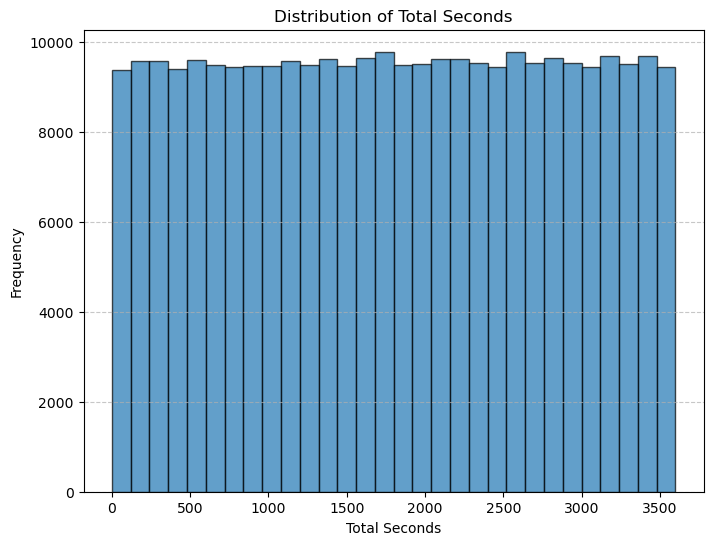

In [55]:
import matplotlib.pyplot as plt

# Plot the distribution of total seconds
plt.figure(figsize=(8, 6))
plt.hist(df['total_seconds'], bins=30, alpha=0.7, edgecolor='black')
plt.title('Distribution of Total Seconds')
plt.xlabel('Total Seconds')
plt.ylabel('Frequency')
plt.ylim(bottom=0) #Change starting point 
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


## AB Test


### Step1: Define the experiment Goals

<b>AB Test subject: 페이지 바꾸기</b>
- Primary Metric: Conversion rate (column converted). - 전환율
- Secondary Metrics: Time spent on the page (total_seconds). - 머무는 시간

### Step2: Understand Group

#### Distribution of Group

In [56]:
import pandas as pd
group_counts = df['group'].value_counts()
group_ratios = group_counts / group_counts.sum()
print(group_ratios)

treatment    0.500181
control      0.499819
Name: group, dtype: float64


#### Distribution of Group & Landing Page

In [57]:
df.groupby(['group','landing_page']).agg({'landing_page': lambda x: x.value_counts()})

,,landing_page
group,landing_page,
control,old_page,143293
treatment,new_page,143397


In [58]:
df.groupby(['group','landing_page']).agg({'landing_page': lambda x: x.value_counts()/group_counts.sum()})

,,landing_page
group,landing_page,
control,old_page,0.499819
treatment,new_page,0.500181


#### Conversion Rate by Landing Page

In [75]:
df.groupby(['landing_page', 'group'])['converted'].mean().reset_index() # old page의 conversion rate가 약간 더 높음

,landing_page,group,converted
0,new_page,treatment,0.118726
1,old_page,control,0.120173


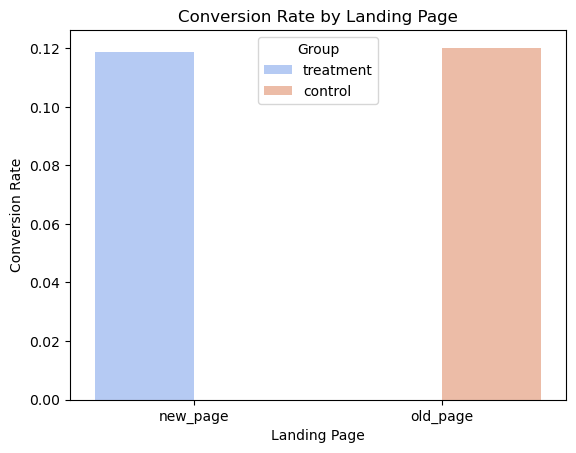

In [76]:
import seaborn as sns 

page_conversion = df.groupby(['landing_page', 'group'])['converted'].mean().reset_index()

sns.barplot(data=page_conversion, x='landing_page', y='converted', hue='group', palette='coolwarm')
plt.title('Conversion Rate by Landing Page')
plt.ylabel('Conversion Rate')
plt.xlabel('Landing Page')
plt.legend(title='Group', loc='upper center')
plt.show()

#### Conversion rate by Group & Landing Page

In [77]:
df.groupby(['group','landing_page']).agg({'converted': 'mean'})


,,converted
group,landing_page,
control,old_page,0.120173
treatment,new_page,0.118726


In [80]:
conversion_summary = df.groupby('group')['converted'].mean().reset_index()
conversion_summary.columns = ['Group', 'Conversion Rate'] # group, converted -> Group, Conversion Rate

print(conversion_summary)


       Group  Conversion Rate
0    control         0.120173
1  treatment         0.118726


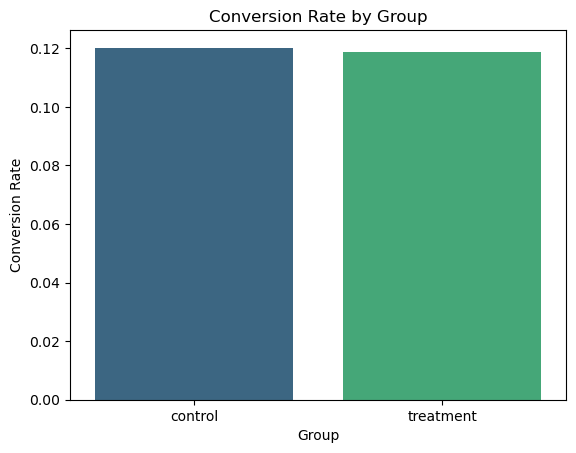

In [81]:
import seaborn as sns  

sns.barplot(data=conversion_summary, x='Group', y='Conversion Rate', palette='viridis')
plt.title('Conversion Rate by Group')
plt.ylabel('Conversion Rate')
plt.xlabel('Group')
plt.show()

### Step3: Forulate Hypothesis

1. Conversion Rate  
- <b>H0(Null Hypothesis)</b>: pA = pB; 그룹 간 전환율에는 차이가 없습니다;  
이전 페이지(old page)와 새 페이지(new page) 간에 통계적으로 유의미한 차이가 없습니다.
- <b>H1(Alternative Hypothesis)</b>: pA ≠ pB; Treatment group은 전환율(conversion rate)이 더 높습니다;  
이전 페이지(old page)와 새 페이지(new page) 간에 통계적으로 유의미한 차이가 있습니다.
2. Time on Page
- <b>H0(Null Hypothesis)</b>: pA = pB; 그룹 간 페이지에 머무는 시간에는 차이가 없습니다;  
이전 페이지(old page)와 새 페이지(new page) 간에 통계적으로 유의미한 차이가 없습니다.
- <b>H1(Alternative Hypothesis)</b>: pA ≠ pB; Treatment group은 머무는 시간(Total seconds)이 더 깁니다;  
이전 페이지(old page)와 새 페이지(new page) 간에 통계적으로 유의미한 차이가 있습니다.

### Step4: Analyze Metrics

#### A: Conversion Rate

In [124]:
0.120173 - 0.118726

0.0014470000000000038

In [125]:
conversion_rates = df.groupby('group')['converted'].mean() # 0.001 -> 0.1% 차이
print(conversion_rates)

group
control      0.120173
treatment    0.118726
Name: converted, dtype: float64


#### B. Time on Landing Page

In [126]:
time_metrics = df.groupby('group')['total_seconds'].mean() # 3.55초 차이
print(time_metrics)

group
control      1804.832314
treatment    1801.277402
Name: total_seconds, dtype: float64


### Step5: Statistical Testing
- two proportion Z-Test: 두 그룹의 비율을 비교 검정하기 위해 활용

#### A. Test - Conversion Rates

In [127]:
from statsmodels.stats.proportion import proportions_ztest

control = df[df['group'] == 'control']['converted']
treatment = df[df['group'] == 'treatment']['converted']

control_converted = control.sum()
treatment_converted = treatment.sum()

#Size of group 
n_control = len(control)
n_treatment = len(treatment)

print(f'control 그룹 전환 수: {control_converted}, treatment 그룹 전환 수: {treatment_converted}')
print(f'control 그룹 수: {n_control}, treatment 그룹 수: {n_treatment}')

stat, p_value = proportions_ztest([control_converted, treatment_converted],
                                   [n_control, n_treatment])
print(f"Z-test Statistic: {stat}, p-value: {p_value:.6f}") 
# 두 그룹 비율 차이가 표준 정규 분포에서 약 1.19 표준편차만큼 떨어져 있음. p-value가 높으므로 귀무가설 유지

control 그룹 전환 수: 17220, treatment 그룹 전환 수: 17025
control 그룹 수: 143293, treatment 그룹 수: 143397
Z-test Statistic: 1.1944850812796501, p-value: 0.232288


__Results__: 
- Z-test: Z-검정 통계량은 관찰된 비율(전환율; conversion rate)의 차이가 표준 오차를 기준으로  
귀무 가설(null hypothesis)에서 얼마나 떨어져 있는지를 정량화합니다.  
값이 1.194라는 것은 관찰된 차이가 0(집단 간 차이가 없다는 귀무 가설)에서  
1.194 표준 오차(standard error) 만큼 떨어져 있음을 나타냅니다.

- P-value: p-값은 귀무 가설(null hypothesis; 두 집단 간에 실제 차이가 없다고 가정) 하에서  
1.194와 같은 극단적인 검정 통계량(또는 그 이상)을 관찰할 확률을 나타냅니다.  
p-값이 0.232라는 것은 관찰된 차이가 우연에 의해 발생할 확률이 23.2%임을 의미하며,  
이는 일반적인 기준(ex: 0.05)에서 통계적으로 유의하지 않음을 나타냅니다.

__Interpretation__:
- 귀무가설; Null Hypothesis (H₀): 대조군과 실험군 간의 전환율(conversion rate)에 차이가 없다
- 대립 가설; Alternative Hypothesis (H₁): 두 집단 간의 전환율(conversion rate)에 차이가 있다

p-value(0.232)가 0.05보다 크기 때문에 귀무 가설(Hull hypothesis)을 기각할 수 없습니다.  
이는 실험군(treatment group)이 대조군(control group)에 비해 전환율 측면에서  
다르게(더 좋거나 나쁘게) 작동한다고 결론을 내릴 충분한 증거가 없음을 의미합니다.  
--> 귀무 가설을 기각하지 못했습니다. 새로운 페이지(new page)와 기존 페이지(old page) 간에  
통계적으로 유의미한 차이가 없으므로 이익을 가져오지 못합니다.

#### B. Test for Time on Page



In [128]:
from scipy.stats import ttest_ind

control_time = df[df['group'] == 'control']['total_seconds']
treatment_time = df[df['group'] == 'treatment']['total_seconds']

t_stat, p_value = ttest_ind(control_time, treatment_time)
print(f"T-test Statistic: {t_stat}, p-value: {p_value:.6f}")


T-test Statistic: 0.9167220080609694, p-value: 0.359289


__Result__: 
- T-test Statistic: T-검정 통계량: 0.917
이 값은 대조군(control)과 실험군(treatment) 간의 평균 차이(랜딩 페이지에서의 평균 시간)가 표준 오차를 기준으로 얼마나 차이가 나는지를 정량화한 것입니다. T-검정 통계량이 0.917이라는 것은 관찰된 차이가 0(Null hypothesis; 귀무 가설: 두 집단 간 차이가 없다는 가정)에서 0.917 표준 오차(stanrad error)만큼 떨어져 있음을 의미합니다.

- p-value: p-값: 0.359
p-값은 귀무 가설(Null hypothesis) 하에서 0.917과 같은 극단적인 검정 통계량(또는 그 이상)을 관찰할 확률을 나타냅니다. p-값이 0.359라는 것은 total_seconds에서 관찰된 차이가 우연에 의해 발생할 확률이 35.9%임을 의미하며, 이는 일반적인 기준(ex: 0.05)에서 통계적으로 유의미하지 않음을 나타냅니다.

__Interpretation__: 
- Null Hypothesis; 귀무가설 (H₀): 대조군(control)과 실험군(treatment) 간의 평균 total_seconds(랜딩 페이지에서 보낸 시간)에 차이가 없다.
- Alternative Hypothesis; 대립가설 (H₁): 두 집단 간의 평균 총_seconds에 차이가 있다.
- p-값(0.359)이 0.05보다 크기 때문에 귀무 가설(H₀)을 기각할 수 없습니다. 이는 실험이 사용자가 랜딩 페이지에서 보내는 시간에 영향을 미친다는 유의미한 증거가 없음을 의미합니다.